In [2]:
import numpy as np
import scipy.fftpack as fft
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
import scienceplots

In [3]:
plt.style.use(['science', 'no-latex'])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import pi

class GaussianFourierFeatureTransform(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = torch.randn((num_input_channels, mapping_size)) * scale

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)


In [12]:
residual_vector = np.loadtxt('../data/simulation_data/res_1000.dat')
eigenvector = np.loadtxt('../data/eigenvectors_data/b_1000.dat')

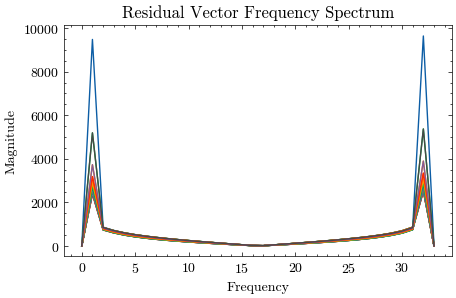

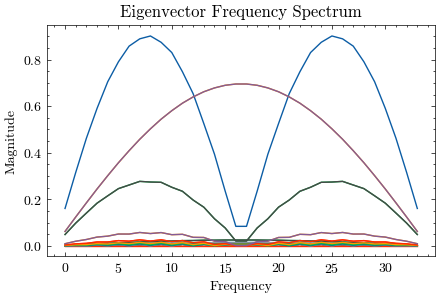

In [13]:
# Compute the FFT
residual_vector_fft = np.fft.fft(residual_vector)
eigenvector_fft = np.fft.fft(eigenvector)

# Compute the magnitude of the FFT
residual_vector_magnitude = np.abs(residual_vector_fft)
eigenvector_magnitude = np.abs(eigenvector_fft)

# Plot the frequency spectrum
def plot_frequency_spectrum(magnitude, title):
    plt.figure(figsize=(5, 3))
    plt.plot(magnitude)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

plot_frequency_spectrum(residual_vector_magnitude, 'Residual Vector Frequency Spectrum')
plot_frequency_spectrum(eigenvector_magnitude, 'Eigenvector Frequency Spectrum')

/home/glatzl/miniconda3/envs/bachelor-thesis/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/glatzl/miniconda3/envs/bachelor-thesis/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


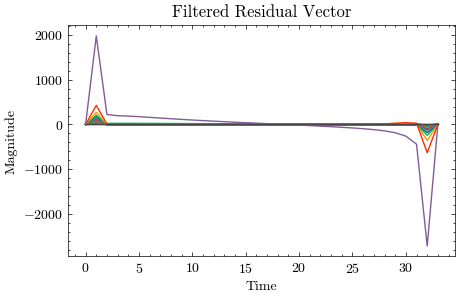

In [7]:
# low-pass filter at the middle frequency
residual_vector_fft_filtered = residual_vector_fft.copy()

# Set the high frequency components to zero
residual_vector_fft_filtered[100:900] = 0
residual_vector_filtered = np.fft.ifft(residual_vector_fft_filtered)

# Plot the filtered residual vector
plt.figure(figsize=(5, 3))
plt.plot(residual_vector_filtered)
plt.title('Filtered Residual Vector')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.show()

In [8]:
# List all residual vectors in the folder
residual_vectors = []
for filename in os.listdir('../data/simulation_data/'):
    if filename.startswith('res_'):
        residual_vector = np.loadtxt(os.path.join('../data/simulation_data/', filename))
        residual_vectors.append(residual_vector)

# Compute FFT and store the magnitudes
frequencies = []
for residual_vector in residual_vectors:
    residual_vector_fft = np.fft.fft(residual_vector)
    residual_vector_magnitude = np.abs(residual_vector_fft)
    frequencies.append(residual_vector_magnitude)

# Convert to a numpy array
frequencies = np.array(frequencies)

# Calculate the mean and standard deviation
mean = np.mean(frequencies, axis=0)
std = np.std(frequencies, axis=0)

In [9]:
mean = mean.flatten()
std = std.flatten()

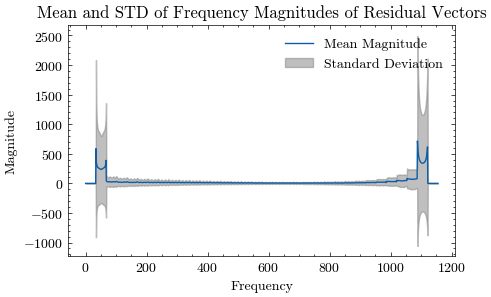

In [10]:
# Plot the mean and standard deviation
plt.figure(figsize=(5, 3))
plt.plot(mean, label='Mean Magnitude')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.5, label='Standard Deviation')
plt.title('Mean and STD of Frequency Magnitudes of Residual Vectors')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig('mean_frequency_spectrum.pdf')
plt.show()

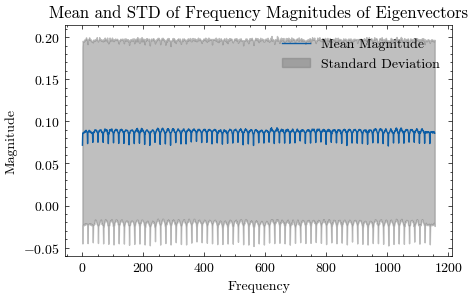

In [11]:
# List all eigenvector vectors in the folder
eigenvector_vectors = []
for filename in os.listdir('../data/eigenvectors_data/'):
    if filename.startswith('b_'):
        eigenvector_vector = np.loadtxt(os.path.join('../data/eigenvectors_data/', filename))
        eigenvector_vectors.append(eigenvector_vector)

# Compute FFT and store the magnitudes
frequencies = []
for eigenvector_vector in eigenvector_vectors:
    eigenvector_vector_fft = np.fft.fft(eigenvector_vector)
    eigenvector_vector_magnitude = np.abs(eigenvector_vector_fft)
    frequencies.append(eigenvector_vector_magnitude)

# Convert to a numpy array
frequencies = np.array(frequencies)

# Calculate the mean and standard deviation
mean = np.mean(frequencies, axis=0)
std = np.std(frequencies, axis=0)
mean = mean.flatten()
std = std.flatten()
# Plot the mean and standard deviation
plt.figure(figsize=(5, 3))
plt.plot(mean, label='Mean Magnitude')
plt.fill_between(range(len(mean)), mean - std, mean + std, color='gray', alpha=0.5, label='Standard Deviation')
plt.title('Mean and STD of Frequency Magnitudes of Eigenvectors')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()
plt.savefig('mean_frequency_spectrum_eigenvectors.pdf')
plt.show()